# Package imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import snebeat.behav_tools as bat
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from glob import glob
from tqdm import tqdm
from path import Path

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Custom functions

In [14]:
def only_annotated(segments, bounds):
    '''
    Removes tube test segments that don't have any behavioural annotations
    '''
    
    retained_segments = []
    retained_bounds = []
    for segment, bound in zip(segments, bounds):

        annotated = segment[['push', 'retreat']].sum().sum() > 0
        
        if annotated:
            retained_segments.append(segment)
            retained_bounds.append(bound)
            
    return retained_segments, retained_bounds, annotated

def infer_TT_outcomes(segments, bounds):
    '''
    Determine if each tube test was won or lost and label every timepoint in the recording as belonging to a winning or losing trial.

    Args:
        - segments, pd.DataFrame:
        - bounds

    Returns:
        - wins, np.array: array of booleans indicating if each tube test was lost or won
        - outcomes, np.array: a boolean sequence indicating for each assay timepoint whether the tube test was won
    '''

    wins = []
    
    for segment in segments:
        pushes = np.where(segment.push)[0]
        retreats = np.where(segment.retreat)[0]

        if len(pushes) == 0:
            wins.append(False)
        elif len(retreats) == 0:
            wins.append(True)
        else:
            if pushes[-1] > retreats[-1]:
                wins.append(True)
            else:
                wins.append(False)

    wins = np.array(wins)

    outcomes = np.array([])
    for n, bound in enumerate(bounds):

        start, end = bound

        outcome = wins[n]

        outcome = np.ones((end + 1) - start) * outcome
        outcomes = np.append(outcomes, outcome)

    return wins, outcomes

def outcome_sequence_from_log(logpath, bounds, annotated):
    log = pd.read_excel(logpath)
    wins = np.array(log.outcome)
    wins[wins == 'W'] = 1.
    wins[wins == 'L'] = 0.
    
    wins = wins[annotated]
    
    outcomes = np.array([])
    for n, bound in enumerate(bounds):

        start, end = bound

        outcome = wins[n]

        outcome = np.ones((end + 1) - start) * outcome
        outcomes = np.append(outcomes, outcome)

    return wins, outcomes

def behaviour_by_outcome(test='TT'):

    path = '/Data/behaviour/annotated_tube_tests'
    logpath = '/Data/outcome_logs'
    reference = 'tube test'
    window = None
    
    state_rank_conversion = {'defeated': 'sub',
                             'redefeated': 'sub',
                             'rising': 'dom'}
    
    
    files = glob(f'{path}/*{test}.csv')
    
    columns = ['mouse_ID', 'push', 'resist', 'retreat', 'outcome']
    results = pd.DataFrame(columns=columns)

    for file in tqdm(files):
        
        cage, rank, state = file.split('/')[-1].split('_')[:3]

        if state != 'baseline':
            rank = state_rank_conversion[state]
            
        mouse_ID = f'{cage}_{rank}'
        
        try:
            _, bdf, _, fps = bat.preprocess_behaviour(file)
        except IndexError:
            bdf = pd.read_csv(file)
            fps = 10

        segments, bounds = bat.segment(bdf, state_ref='tube test')
        bdf = pd.concat(segments).reset_index(drop=True)

        segments, bounds, annotated = only_annotated(segments, bounds)
            
        try:
            log = Path(logpath)/Path(file).name
            wins, _ = outcome_sequence_from_log(log, bounds, annotated)
        except FileNotFoundError:
            wins, _ = infer_TT_outcomes(segments, bounds)
            
            
        mouse_results = pd.DataFrame(columns=columns)
        for segment, bound, outcome in zip(segments, bounds, wins):

            duration, _, _, _ = bat.behaviour_metrics(segment, reference=reference, window = window, fr=fps)
            behav_metrics = [duration[behav] for behav in ['push', 'resist', 'retreat']]
            
            row = np.append(mouse_ID, behav_metrics)
            row = np.append(row, outcome)
            mouse_results = pd.concat([mouse_results, 
                                       pd.DataFrame(row.reshape(1,5), columns=columns)])
            
        results = pd.concat([results, mouse_results])

    results = pd.DataFrame(results)
    results[['push', 'resist', 'retreat']] = results[['push', 'resist', 'retreat']].astype(float)
    
    return results

def show_sig_label(p, x, y):

    sig_label = ['n.s.', '*', '**', '***', '****'][(p < [0.05, 0.01, 0.001, 0.0001]).sum()] 
    if sig_label == 'n.s.':
        fontsize = 17
    else:
        fontsize = 25

    plt.text(x, y, sig_label, fontsize=fontsize)

# Segment behavioural data by tube test outcome

In [7]:
results = behaviour_by_outcome()

aggregate_results = results.groupby(['mouse_ID', 'outcome']).agg({
            'push': 'median',
            'resist': 'median',
            'retreat': 'median'})

aggregate_results = aggregate_results.reset_index(drop=False)

100%|██████████| 23/23 [00:07<00:00,  3.27it/s]


# Visualisation

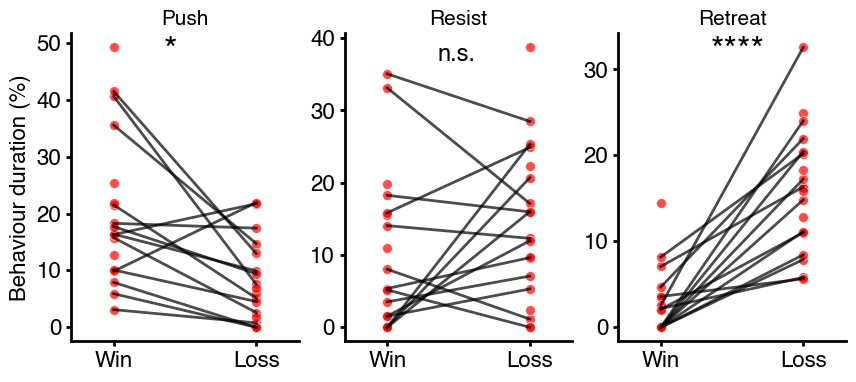

In [16]:
def outcome_plot(aggregate_results, behav):
    
    model = smf.ols(f'{behav} ~ outcome + mouse_ID', aggregate_results).fit()
    p = model.pvalues['outcome[T.True]']

    sns.scatterplot(aggregate_results, x='outcome', y=behav, s=50, c='r', alpha=0.7)

    for name, animal in aggregate_results.groupby('mouse_ID'):
        sns.lineplot(data=animal, x='outcome', y=behav, color='black', alpha=0.7)
        
    plt.xlim(-0.3, 1.3)
    plt.ylabel('')
    
    plt.xticks([0,1], ['Win', 'Loss'])
    plt.xlabel('')
    
    plt.title(behav.capitalize(), fontsize=15)
    
    show_sig_label(p, 0.35, aggregate_results[behav].max()*0.95)
   
plt.figure(figsize=[10,4])

for n, behav in enumerate(['push', 'resist', 'retreat']):
    plt.subplot(1,3,n+1)
    outcome_plot(aggregate_results, behav)
    
    if n == 0:
        plt.ylabel('Behaviour duration (%)')
        
plt.savefig('../Plots/Behaviour/Outcome dependent TT behaviour', dpi=300, bbox_inches='tight')